In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

import matplotlib.pyplot as plt
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

## Modeling functions 

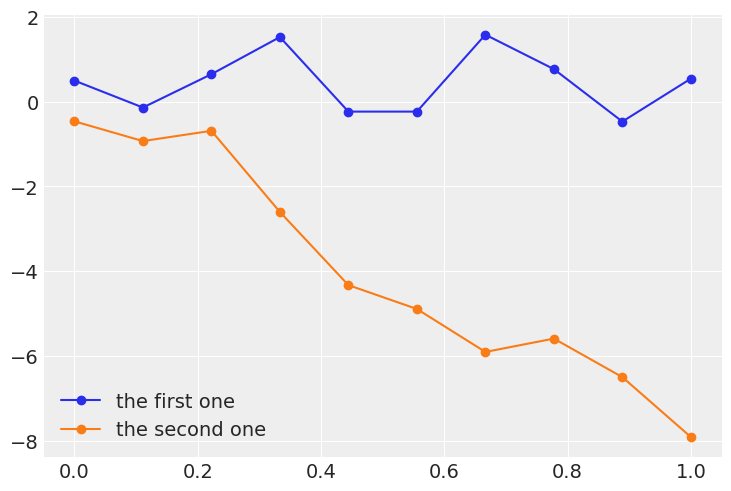

In [42]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend()
plt.savefig('B11197_07_01.png')

### Covariance functions and kernels

In [43]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

In [44]:
#  def linear_kernel(x, knots):
#      """ linear kernel """
#     return np.array([(x - 2) * (k - 2) for k in knots])

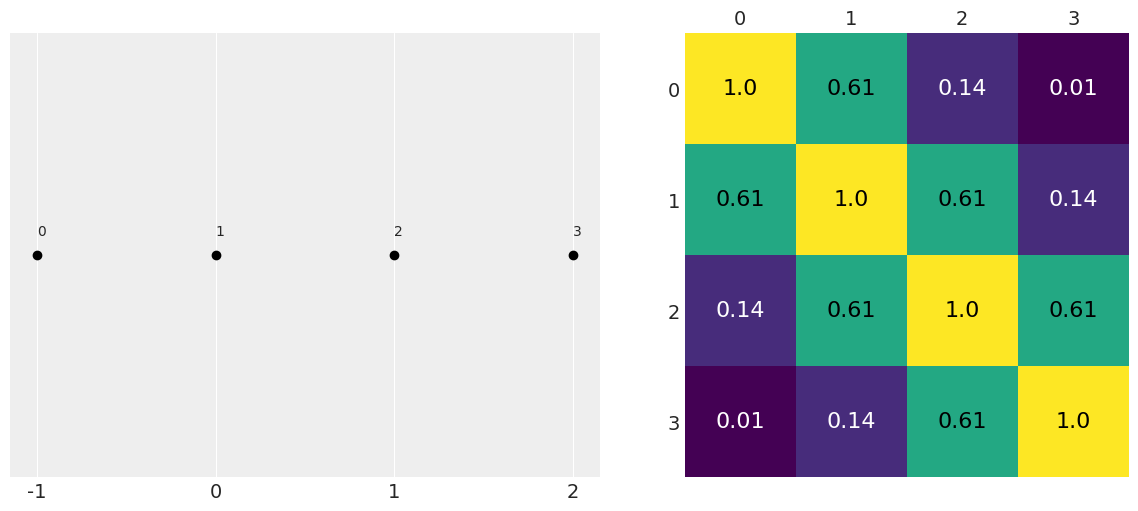

In [45]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()
plt.savefig('B11197_07_02.png')

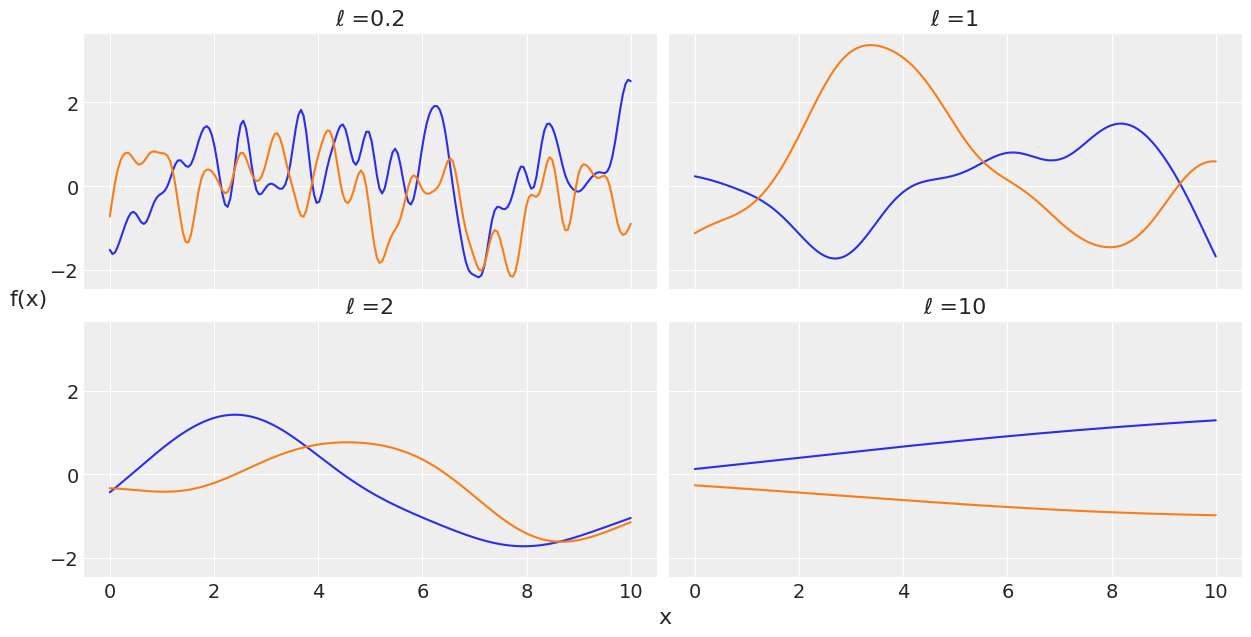

In [46]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.savefig('B11197_07_03.png')

## Gaussian Process regression

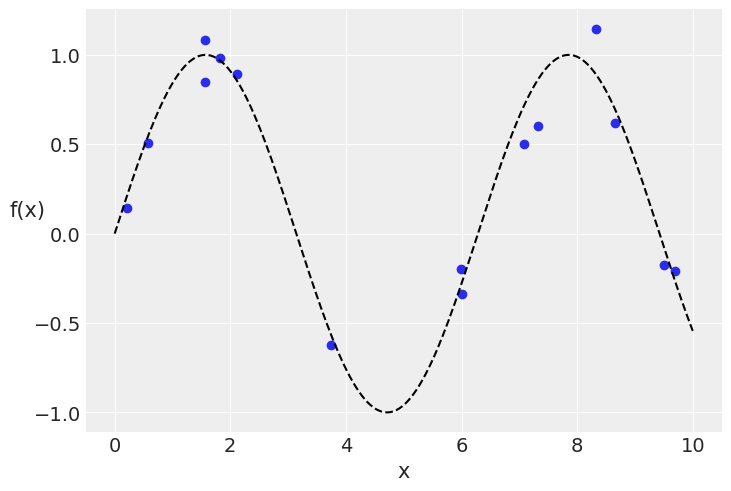

In [47]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
plt.savefig('B11197_07_04.png')

In [48]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    idata_reg = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


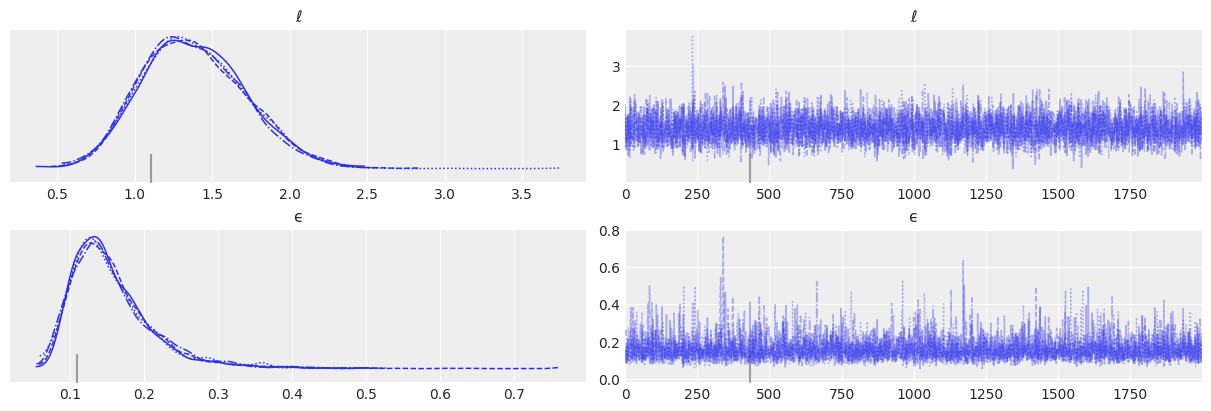

In [49]:
az.plot_trace(idata_reg)
plt.savefig('B11197_07_05.png')

In [50]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [51]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(idata_reg, var_names=["f_pred"], samples=82)

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


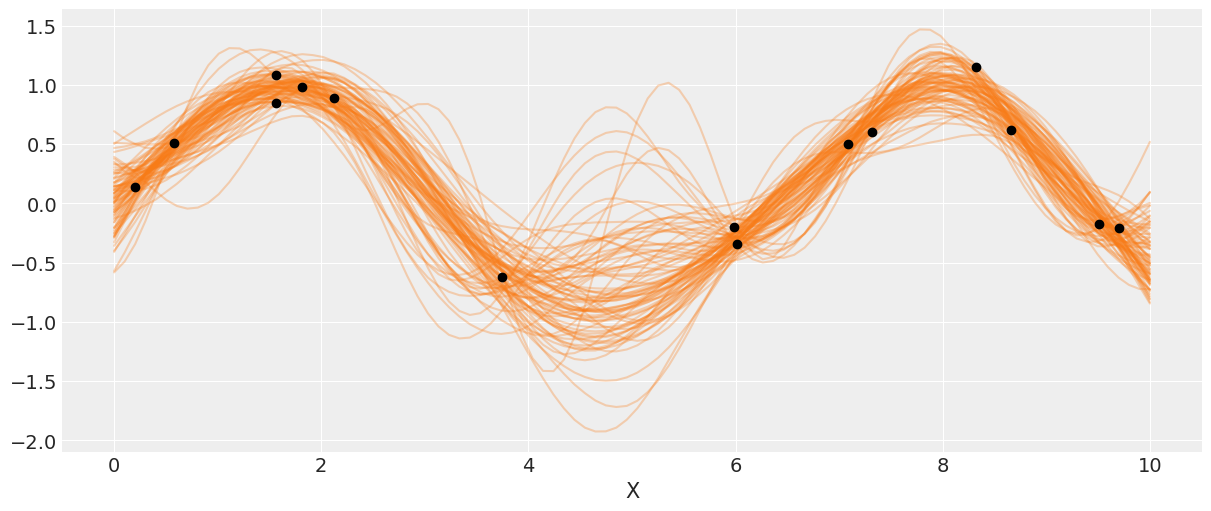

In [52]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_06.png')

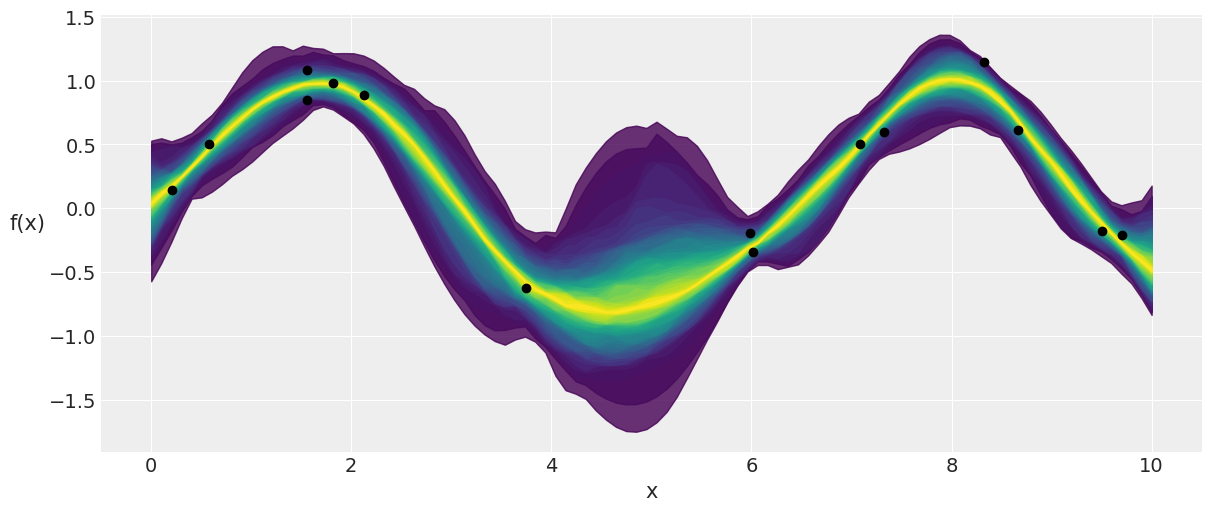

In [53]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('B11197_07_07.png')

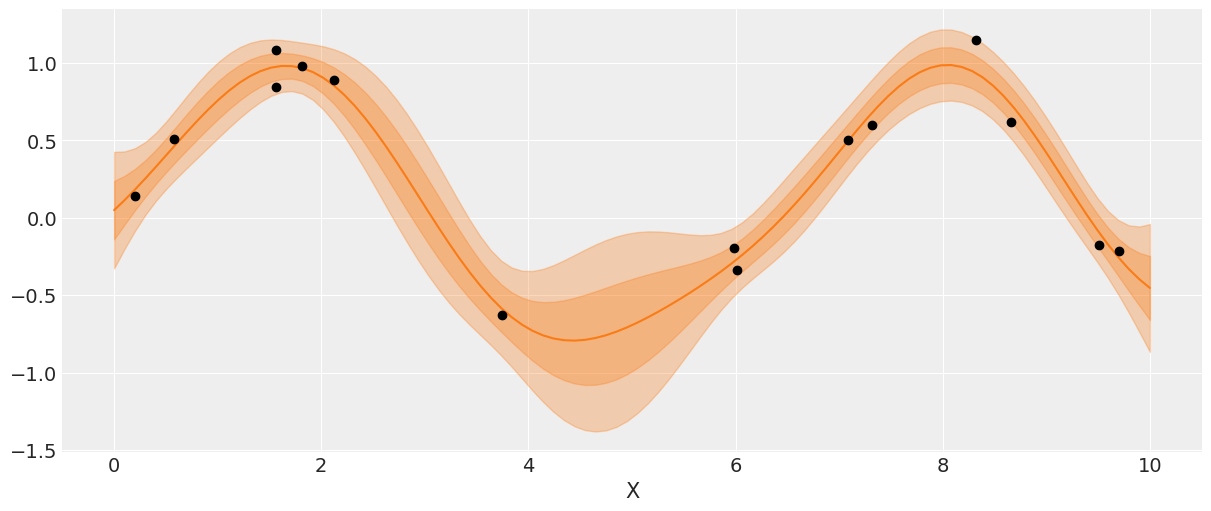

In [54]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'ϵ': idata_reg.posterior['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_08.png')

## Regression with spatial autocorrelation

In [55]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [56]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [57]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [58]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    idata_islands = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 261 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [59]:
idata_islands

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [60]:
az.summary(idata_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.881,1.130,-1.232,3.186,0.036,0.026,1034.0,1131.0,1.0
β,0.285,0.119,0.061,0.519,0.004,0.003,1021.0,989.0,1.0
η,0.273,0.378,0.001,0.775,0.012,0.009,861.0,1234.0,1.0
ℓ,0.932,1.605,0.000,3.015,0.079,0.056,547.0,466.0,1.0
f[0],-0.122,0.353,-0.774,0.557,0.010,0.007,1374.0,1530.0,1.0
f[1],-0.022,0.327,-0.604,0.602,0.008,0.006,1544.0,1687.0,1.0
f[2],-0.011,0.305,-0.577,0.540,0.007,0.005,1750.0,1704.0,1.0
f[3],0.391,0.282,-0.092,0.937,0.007,0.005,1864.0,1805.0,1.0
f[4],0.064,0.275,-0.429,0.570,0.006,0.005,2022.0,1905.0,1.0
f[5],-0.301,0.298,-0.868,0.240,0.007,0.005,1852.0,1451.0,1.0


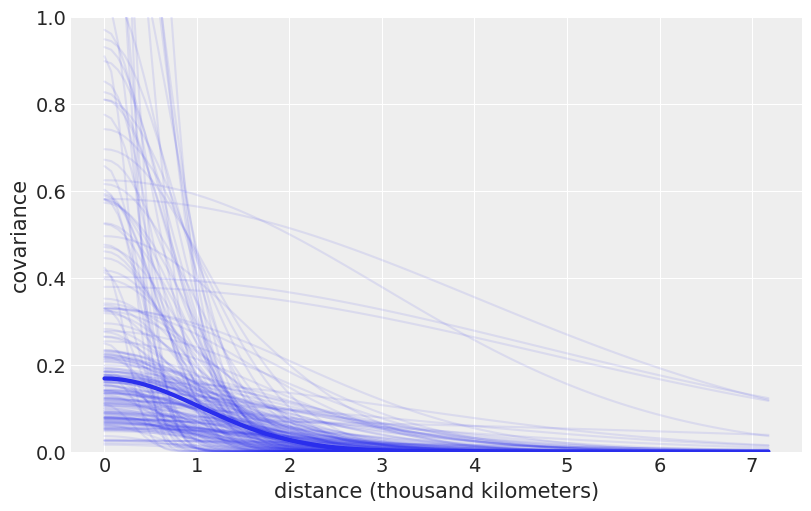

In [61]:
posterior_islands = idata_islands.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')
plt.savefig('B11197_07_09.png')

In [62]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.90,0.83,0.00,0.50,0.15,0.01,0.03,0.20,0.0
Ti,0.90,1.00,0.96,0.00,0.49,0.16,0.02,0.04,0.17,0.0
SC,0.83,0.96,1.00,0.00,0.33,0.26,0.05,0.08,0.09,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.06,0.33,0.30,0.00,0.0
Fi,0.50,0.49,0.33,0.00,1.00,0.01,0.00,0.00,0.76,0.0
Tr,0.15,0.16,0.26,0.06,0.01,1.00,0.22,0.72,0.00,0.0
Ch,0.01,0.02,0.05,0.33,0.00,0.22,1.00,0.51,0.00,0.0
Mn,0.03,0.04,0.08,0.30,0.00,0.72,0.51,1.00,0.00,0.0
To,0.20,0.17,0.09,0.00,0.76,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


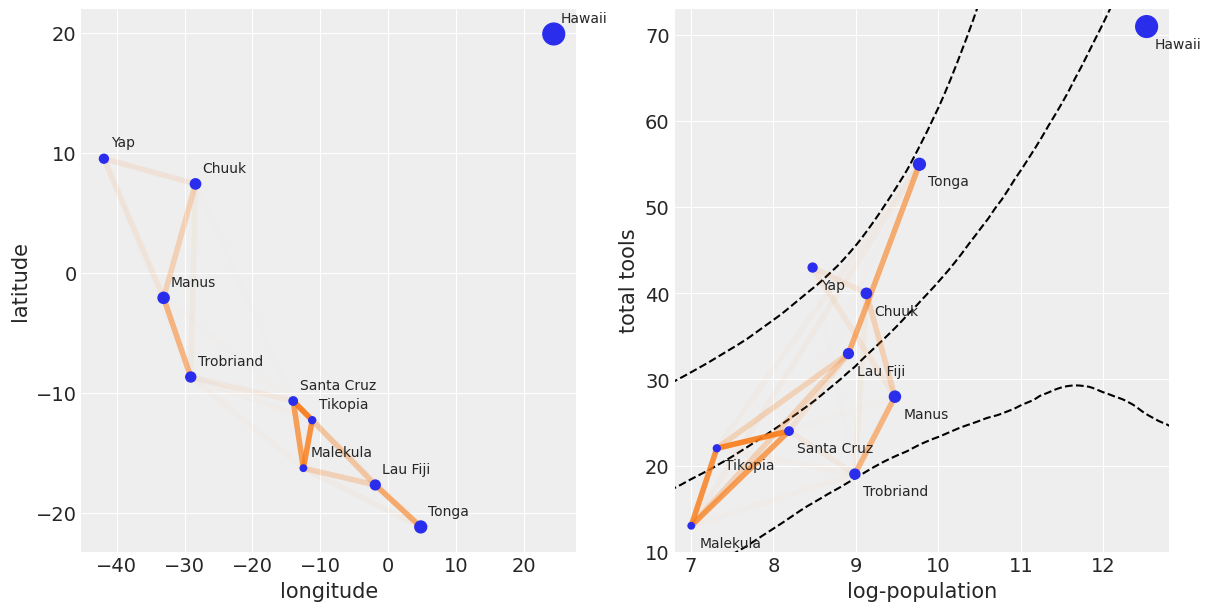

In [63]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.savefig('B11197_07_10.png')

### Gaussian process classification

In [64]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [65]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [66]:
with pm.Model() as model_iris:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ℓ]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 3 chains for 1_000 tune and 565 draw iterations (3_000 + 1_695 draws total) took 82 seconds.


In [ ]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:

    f_pred = gp.conditional('f_pred', X_new) 
    pred_samples = pm.sample_posterior_predictive(idata_iris, var_names=["f_pred"], samples=1000)

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


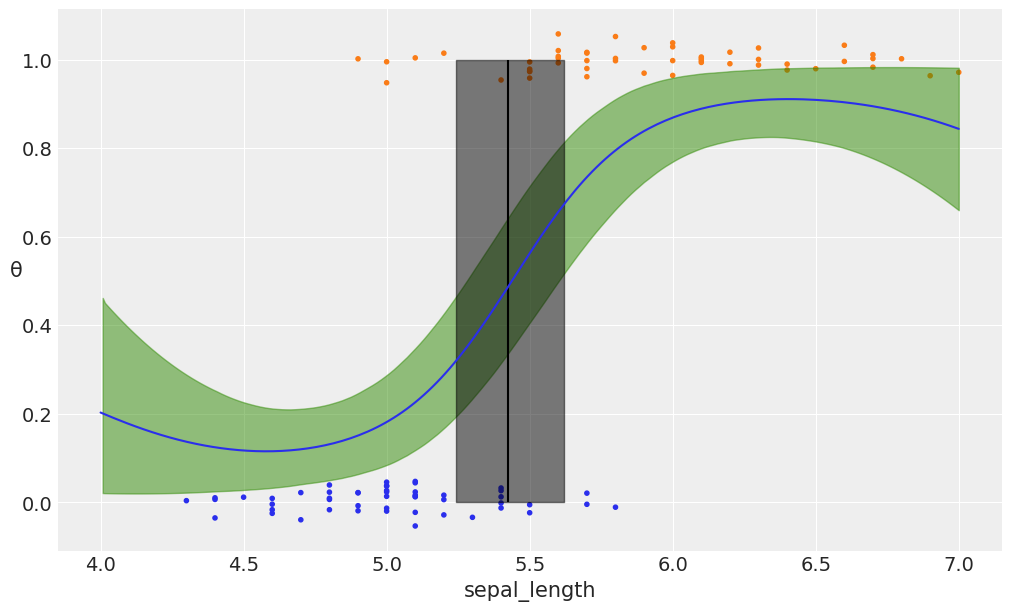

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp, color='C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')

In [ ]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 43 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_iris2,
                                                  var_names=["f_pred"],
                                                  samples=1000)

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


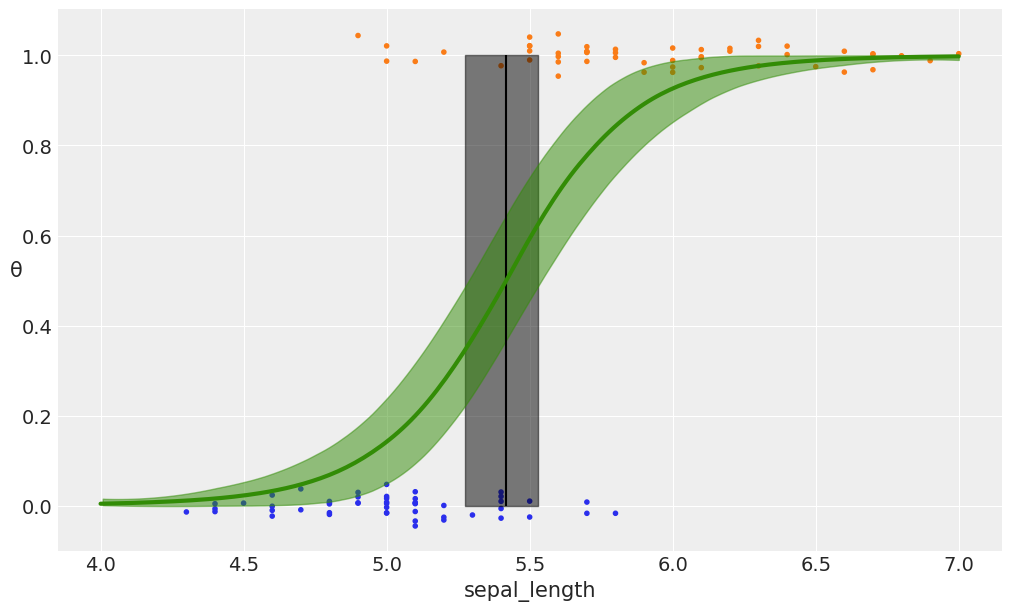

In [ ]:
_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_12.png')

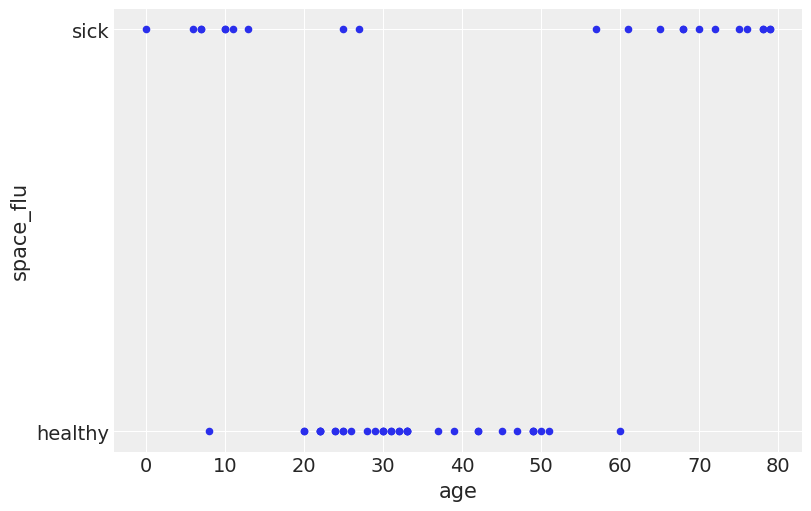

In [ ]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
plt.savefig('B11197_07_13.png', bbox_inches='tight')

In [ ]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_space_flu = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9 seconds.


In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_space_flu,
                                                  var_names=["f_pred"],
                                                  samples=1000)

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


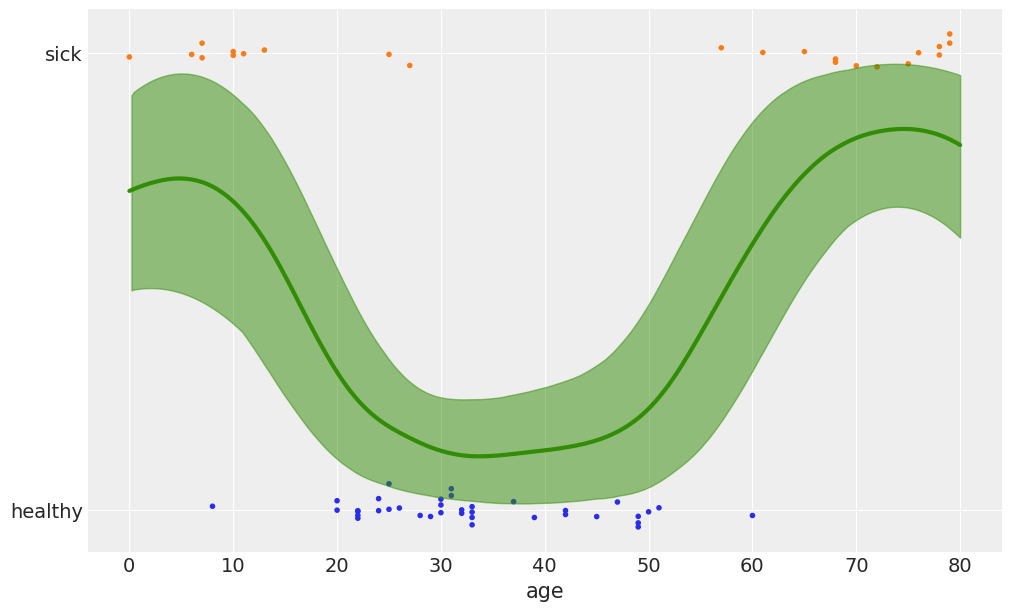

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('B11197_07_14.png')

### the coal-mining disaster

In [5]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142
...,...
186,1947.6872
187,1951.4052
188,1957.8830
189,1960.4894


In [6]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [15]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_coal = pm.sample(1000, chains=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


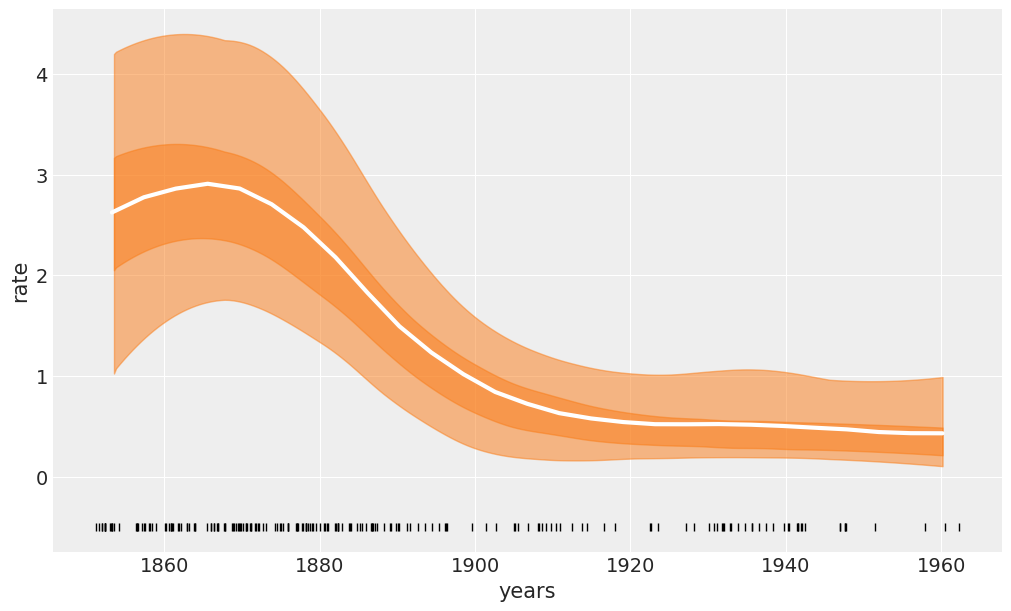

In [16]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T)
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.savefig('B11197_07_15.png')

### the redwood data

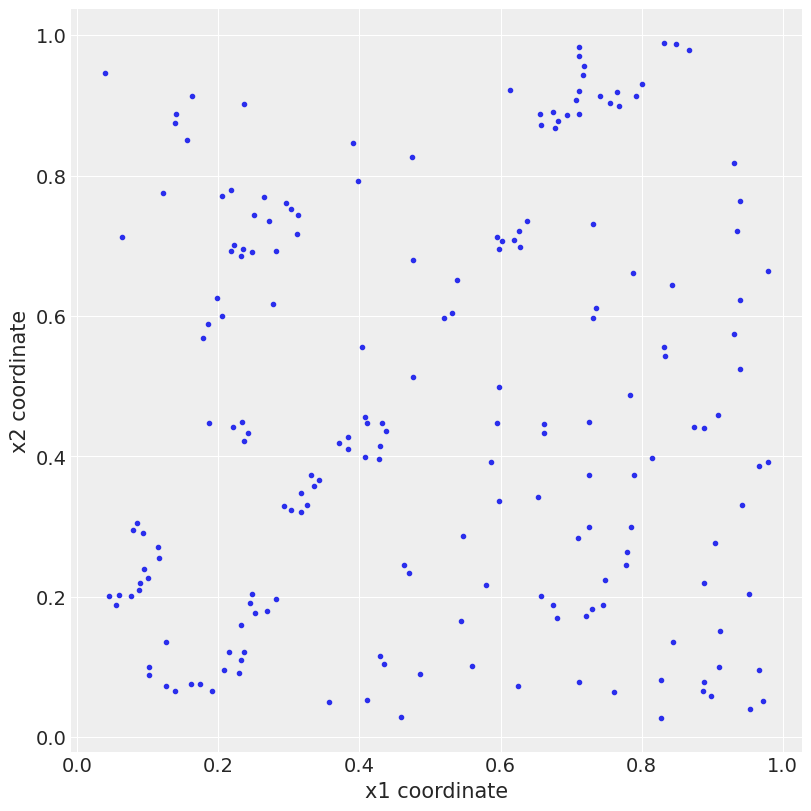

In [41]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.savefig('B11197_07_16.png')

In [42]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [43]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    idata_rw = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [44]:
az.summary(idata_rw, var_names=['ℓ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ[0],0.127,0.040,0.076,0.182,0.003,0.002,252.0,323.0,1.01
ℓ[1],0.094,0.024,0.056,0.140,0.002,0.001,242.0,588.0,1.02


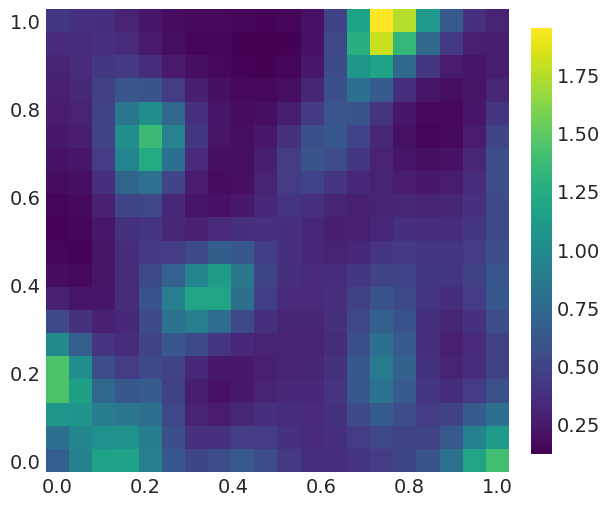

In [45]:
rate = np.exp(np.mean(idata_rw.posterior['f'].stack(samples=("chain", "draw")).T, axis=0).values.reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)
plt.savefig('B11197_07_17.png')